In [21]:
import os
import sys
sys.path.append('/mnt/data01/Code/')
import NDH_Tools as ndh

import glob

import xarray as xr
from matplotlib.colors import BoundaryNorm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm


import earthpy.spatial as es
# Create and plot the hillshade with earthpy

agl_fn = '/mnt/data01/Data/Antarctic_Groundinglines/MODIS_gl_ant/moa_gl.mat'
agl = ndh.loadmat(agl_fn)
ggl_fn = '/mnt/data01/Data/Greenland_Groundinglines/NDH_Greenland_gl/greenland_gl.xy'
ggl = pd.read_table(ggl_fn,delimiter=',',header=None)


dems = []

dems.append(xr.open_dataset('/mnt/data01/Data/Greenland_BedElevation/BedMachineGreenland-v5-2022-09-01.nc'))
dems.append(xr.open_dataset('/mnt/data01/Data/Antarctic_BedElevation/bedmap3.nc'))
#dems.append(xr.open_dataset('/mnt/data01/Data/Antarctic_BedElevation/BedMachineAntarctica-v3-2022-10-11.nc'))

bed_key = ['bed','bed_topography','bed']
mask_key = ['mask','mask','mask']
mask_target = [2,1,2]

In [22]:
##################################
### Load LeysingerVieli Picks

peak_coords = ndh.loadmat('../Petermann_SwathWork/Published_Datasets/LeysingerVieli_BodyPicks/complete_plumbigpeakpoints_clear_sieved.mat')
peak_keys = list(peak_coords.keys())
key_pairs = [[7,9],[8,10],[11,12],[13,15],[14,16]]

total_x = []
total_y = []
for i in key_pairs:
    key1 = peak_keys[i[0]]
    key2 = peak_keys[i[1]]
    total_x.append(peak_coords[key1])
    total_y.append(peak_coords[key2])

total_x = ndh.flatten_list(total_x)
total_y = ndh.flatten_list(total_y)

In [56]:
#####################################
### Load Attenuation Picks
bp = ndh.loadmat('../Petermann_AttenuationCalculations/PowerDifferences_v8.mat')
bp['x_center'] = []
bp['y_center'] = []
for ind in tqdm.tqdm(np.arange(len(bp['x']))):
    bp['x_center'].append(np.mean(bp['x'][ind]))
    bp['y_center'].append(np.mean(bp['y'][ind]))

power_loss = np.stack(bp['meanpowerloss'])
pl_x = np.stack(bp['x_center'])
pl_y = np.stack(bp['y_center'])
ki = np.where(power_loss < -10)
pl_x = pl_x[ki]
pl_y = pl_y[ki]

100%|██████████████████████████████████████| 602/602 [00:00<00:00, 89004.58it/s]


In [54]:
#####################################
### Load XTrack Scattering Picks
pick_files = glob.glob('../Petermann_Debris_Identification/Picks/*.mat')
xtrack = {'x':[],'y':[]}
for pf in pick_files:
    pick = ndh.loadmat(pf)
    xy = ndh.polarstereo_fwd(pick['Latitude'],pick['Longitude'])
    for pvals in pick['picks']:
        ki = np.where(~np.isnan(pvals))[0]
        xtrack['x'].append(xy['x'][ki[0::10]])
        xtrack['y'].append(xy['y'][ki[0::10]])

xtrack['x'] = np.concatenate(xtrack['x'])
xtrack['y'] = np.concatenate(xtrack['y'])

xtrack['x'].shape

(4946,)

In [25]:
if os.path.isfile('Roughness_10km.mat'):
    roughness_dict = ndh.loadmat('Roughness_10km.mat')

else: 
    roughness_scale = 10000
    ds_fac = 1000
    ras = []
    rmss = []
    nxs = []
    nys = []
    hillshades = []
    
    for dem_ind,dem in enumerate(dems):
        dx = dem['x'].values[1] - dem['x'].values[0]
        ds = int(ds_fac/dx)
    
        nx = dem['x'].values[::ds]
        ny = dem['y'].values[::ds]
        
        index_range = int(roughness_scale/dx/2)
        ra = np.zeros([len(ny),len(nx)])
        rms = np.zeros([len(ny),len(nx)])
    
        for row in tqdm.tqdm(np.arange(len(ny))):
            for col in np.arange(len(nx)):
                if dem[mask_key[dem_ind]][row*ds,col*ds] == mask_target[dem_ind]:
                    lix = np.max([0,col*ds-index_range])
                    hix = np.min([len(dem['x'].values),col*ds+index_range])
                    liy = np.max([0,row*ds-index_range])
                    hiy = np.min([len(dem['y'].values),row*ds+index_range])
        
                    dem_sub = dem[bed_key[dem_ind]][liy:hiy+1,lix:hix+1].values
                    sub_size = np.prod(dem_sub.shape)
                    mv = np.mean(dem_sub)
                    ra_val = np.sum(np.abs(dem_sub-mv))/sub_size
                    rms_val = np.sqrt(np.sum(np.abs(dem_sub-mv)**2/sub_size))
        
                    ra[row,col] = ra_val
                    rms[row,col] = rms_val
                else:
                    ra[row,col] = np.nan
                    rms[row,col] = np.nan
        ras.append(ra)
        rmss.append(rms)
        nxs.append(nx)
        nys.append(ny)
    
        hs =es.hillshade(dem[bed_key[dem_ind]])
        hillshades.append(hs)
                
    roughness_dict = {'rms':rmss,'ra':ras,'nx':nxs,'ny':nys, 'hillshades':hillshades}
    ndh.savemat(roughness_dict,'Roughness_10km.mat')

In [12]:
em

,Continent,Lat,Lon,Source,Notes
0,Ant,-73.50,2.5,"Franke, S., Wolovick, M., Drews, R., Jansen, D...",Hightlights weak and strong backscattering phe...
1,Ant,-84.00,170.0,"Kassab, C. M., Licht, K. J., Petersson, R., Li...",This has cosmo ages showing stagnation
2,Ant,-80.33,-81.0,"Winter, K., Woodward, J., Ross, N., Dunning, S...",Flags
3,Ant,-81.00,75.0,"Bell, R. E., Ferraccioli, F., Creyts, T. T., B...",Gamburtsevs
4,Gre,69.75,-53.3,Larsen,Disko Island -- Repeat Isotopes


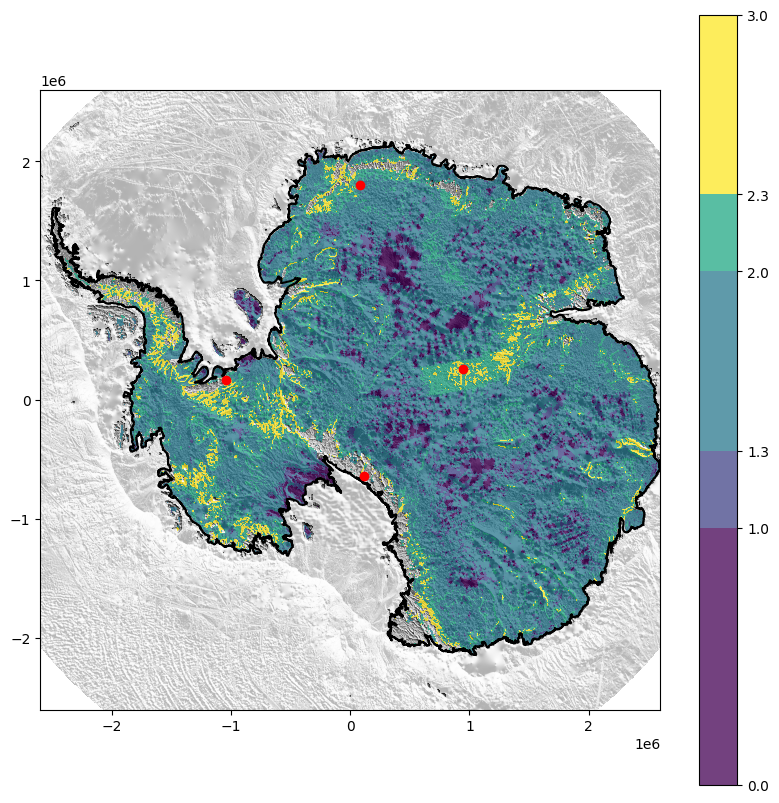

In [18]:
###################################################
### Antarctic Map
###################################################
em = pd.read_excel('./Entrainment_in_Literature.xlsx')
ki = em['Continent'] == 'Ant'
xy = ndh.polarstereo_fwd(em['Lat'],em['Lon'])


divisions = [0, 1,1.3, 2,2.3, 3]
cmap = plt.get_cmap('viridis', len(divisions))
norm = BoundaryNorm(divisions, cmap.N)

ti = 1

dem = dems[ti]
new_mask = np.array(dem[mask_key[ti]].values != mask_target[ti]).astype(float)
new_mask[new_mask == 0] = np.nan

plt.figure(figsize=(10,10))
plt.imshow(roughness_dict['hillshades'][ti],
           extent=[roughness_dict['nx'][ti][0],roughness_dict['nx'][ti][-1],roughness_dict['ny'][ti][0],roughness_dict['ny'][ti][-1]],
           cmap='Grays',origin='lower')

plt.imshow(new_mask,
           extent=[roughness_dict['nx'][ti][0],roughness_dict['nx'][ti][-1],roughness_dict['ny'][ti][0],roughness_dict['ny'][ti][-1]],
           cmap='Grays',origin='lower',alpha=0.7)

cdata = plt.imshow(np.log10(roughness_dict['ra'][ti]),
                   extent=[roughness_dict['nx'][ti][0],roughness_dict['nx'][ti][-1],roughness_dict['ny'][ti][0],roughness_dict['ny'][ti][-1]],
                    cmap=cmap,norm=norm,alpha=0.75,origin='lower')

plt.plot(agl['gl'][:,0],agl['gl'][:,1],c='black')
plt.plot(xy['x'],xy['y'],'o',c='red')
plt.colorbar(cdata,ticks=divisions,spacing='proportional')
val = 2.6e6;
plt.xlim([-val,val])
plt.ylim([-val,val])


plt.savefig('Antarctica.pdf')

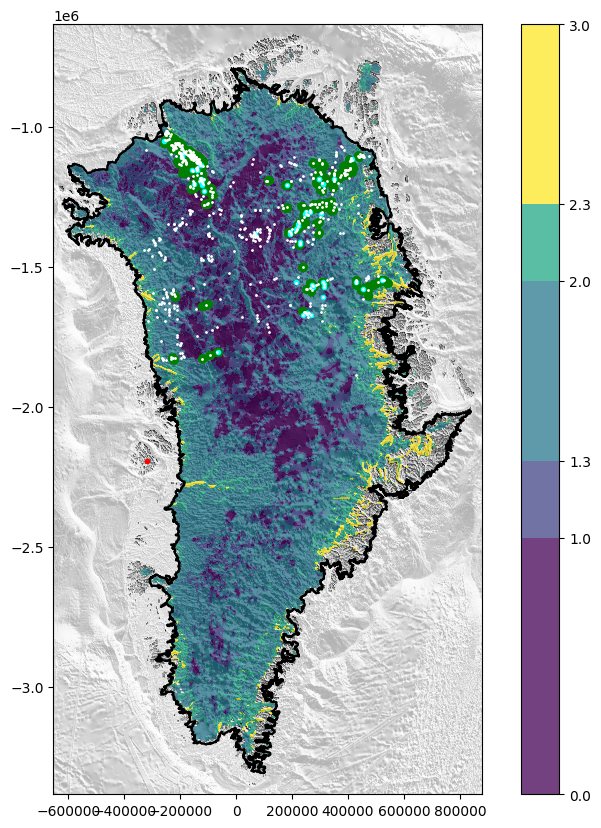

In [57]:
###################################################
### Greenland Map
###################################################


em = pd.read_excel('./Entrainment_in_Literature.xlsx')
ki = em['Continent'] == 'Gre'
xy = ndh.polarstereo_fwd(em['Lat'][ki],em['Lon'][ki])

divisions = [0, 1,1.3, 2,2.3, 3]
cmap = plt.get_cmap('viridis', len(divisions))
norm = BoundaryNorm(divisions, cmap.N)

ti = 0

dem = dems[ti]
new_mask = np.array(dem[mask_key[ti]].values != mask_target[ti]).astype(float)
new_mask[new_mask == 0] = np.nan

plt.figure(figsize=(10,10))
plt.imshow(roughness_dict['hillshades'][ti],
           extent=[roughness_dict['nx'][ti][0],roughness_dict['nx'][ti][-1],roughness_dict['ny'][ti][0],roughness_dict['ny'][ti][-1]],
           cmap='Grays',origin='lower')

plt.imshow(new_mask,
           extent=[roughness_dict['nx'][ti][0],roughness_dict['nx'][ti][-1],roughness_dict['ny'][ti][0],roughness_dict['ny'][ti][-1]],
           cmap='Grays',origin='lower',alpha=0.7)

cdata = plt.imshow(np.log10(roughness_dict['ra'][ti]),
                   extent=[roughness_dict['nx'][ti][0],roughness_dict['nx'][ti][-1],roughness_dict['ny'][ti][0],roughness_dict['ny'][ti][-1]],
                    cmap=cmap,norm=norm,alpha=0.75,origin='lower')

plt.plot(ggl[0],ggl[1],c='black')
plt.plot(xtrack['x'],xtrack['y'],'.',c='green',ms=10)
plt.plot(pl_x,pl_y,'.',c='cyan',ms=6)
plt.plot(total_x,total_y,'.',c='white',ms=2)
plt.plot(xy['x'],xy['y'],'.',c='red')

plt.colorbar(cdata,ticks=divisions,spacing='proportional')
plt.gca().invert_yaxis()


plt.savefig('Greenland_v2.pdf')

In [48]:
xtrack['x'].shape


(48378,)

In [37]:
bp.keys()

dict_keys(['filename', 'inds', 'maxpowerloss', 'meanpowerloss', 'width', 'x', 'y', 'x_center', 'y_center'])